**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

df = pa.read_csv('tut_05_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

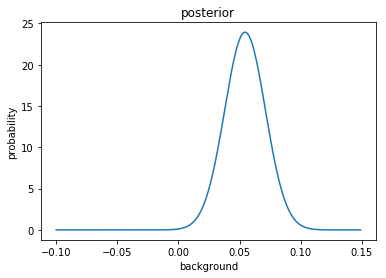

Posterior at edges of parameter space:  5.145873718776107e-18 2.52702008593455e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [0.0545]
The average of posterior  : 0.05453108678141714
The variance of posterior  : 0.016666664987686954


In [3]:

import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print ('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print ('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print ('The average of posterior  :',bave)
print ('The variance of posterior  :',np.sqrt(variance))


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

In [4]:
class line (object):
    
    def __init__ (self, parameters):
        self.A = parameters['A']
        self.lo = parameters['lo']
        self.dl = parameters['dl']
        self.offset = parameters['offset']
        
    def flux (self, lamb):
        exp_fact = -((lamb-self.lo)/self.dl)**2
        return self.A*np.exp(exp_fact) + self.offset

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

lamb = df['wavelength']
flux = df['flux']
sig = df['sigma']

def neg_loglike (parameters):
    param = {'A':parameters[0], 'lo':parameters[1], 'dl':parameters[2], 'offset':parameters[3]}
    lin = line(param)
    delta = flux - lin.flux(lamb)
    return +0.5*np.sum((delta/sig)**2)

data_offset = bave

guess_parameters = {'A':1.1, 'lo':24, 'dl':3, 'offset':0.05}

opt_par = opt.minimize (neg_loglike, [guess_parameters['A'], guess_parameters['lo'], guess_parameters['dl'], guess_parameters['offset']])

opt_parameters = {'A':opt_par.x[0], 'lo':opt_par.x[1], 'dl':opt_par.x[2], 'offset':opt_par.x[3]}

4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

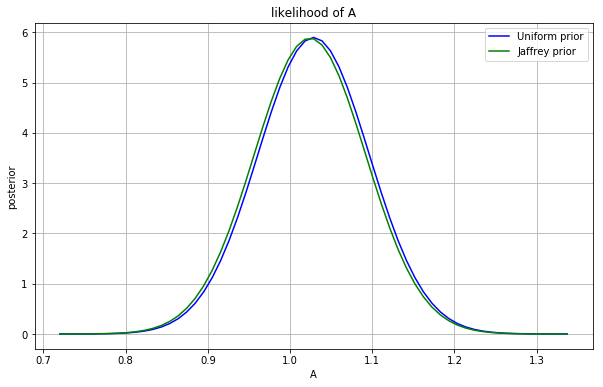

In [8]:
opt_A = opt_par.x[0]
dA = opt_A/100.
A_array = np.arange(0.7*opt_A, 1.3*opt_A, dA)
unif_likel = np.empty(len(A_array))
Jaff_likel = np.empty(len(A_array))

for i in range(len(A_array)):
    param = [A_array[i], opt_parameters['lo'], opt_parameters['dl'], opt_parameters['offset']]
    unif_likel[i] = np.exp(-neg_loglike(param))
    Jaff_likel[i] = np.exp(-neg_loglike(param))/A_array[i]

norm_unif_likel = unif_likel/(np.sum(unif_likel)*dA)
norm_Jaff_likel = Jaff_likel/(np.sum(Jaff_likel)*dA)

plt.figure(figsize=(10,6))
plt.plot(A_array, norm_unif_likel, color='blue', label='Uniform prior')
plt.plot(A_array, norm_Jaff_likel, color='green', label='Jaffrey prior')
plt.xlabel('A')
plt.ylabel('posterior')
plt.title('likelihood of A')
plt.grid()
plt.legend()
plt.show()

5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

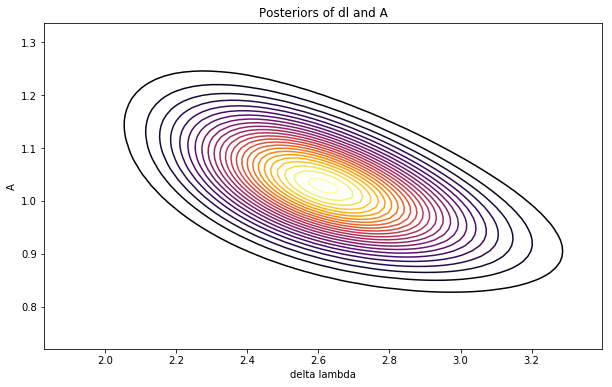

In [9]:
opt_dl = opt_par.x[2]
ddl = opt_dl/100.
dl_array = np.arange(0.7*opt_dl, 1.3*opt_dl, ddl)

N_A = len(A_array)
N_dl = len(dl_array)

likelihood = np.empty([N_A, N_dl])

for i in range(N_A):
    for j in range(N_dl):
        param = [A_array[i], opt_parameters['lo'], dl_array[j], opt_parameters['offset']]
        likelihood[i][j] = np.exp(-neg_loglike(param))

likelihood = likelihood/(np.sum(likelihood)*dA*ddl)

X,Y = np.meshgrid(dl_array, A_array)

plt.figure(figsize=(10,6))
plt.contour(X, Y, likelihood, 30, cmap='inferno')
plt.xlabel('delta lambda')
plt.ylabel('A')
plt.title('Posteriors of dl and A')
#plt.colorbar()
plt.show()

6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

In [4]:
#####

7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.

In [ ]:
#####

8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.

In [59]:
#####

9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

In [84]:
#####

10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 